# Notebook Title: Exploratory Data Analysis for Release QC Metrics

## Description:
This notebook provides an exploratory data analysis for release quality control (QC) metrics.  The notebook utilizes PySpark and pandas for data processing and visualization.

## Notebook Workflow:
1. Import necessary modules and set up the release path and version.
2. Load and analyze the variant index data:
   - Count the number of unique variants.
3. Load and analyze the study index data for different data sources (FinnGen, GWASCat, eQTLcat):
   - Count the number of unique studies for each data source.
4. Analyze the credible sets for each datasource (Finngen, gwascat, eqtlcat):
   - Analyze the credible sets:
     - Count the number of unique credible sets and unique study IDs.
     - Plot a scatter plot of the credible set size vs. the top posterior probability.
     - Count the number of credible sets with a top SNP posterior probability > 0.9..
5. Analyze colocalization data:
   - Count the total number of colocalizations and the number with clpp > 0.8.
   - Calculate the average number of overlaps per credible set.
6. Analyze locus-to-gene (L2G) predictions:
   - Load the locus-to-gene predictions data.
   - How many Studylocus contains a "good" l2g prediction? (l2g_score > 0.5)
   - How does l2g perform based on different datasource inputs? (impossible to tell)
   
Note: This notebook assumes that the necessary data files are available in the specified release path and version.


### Setup steps
##### 1. Import necessary modules and set up the release path and version.

In [1]:
"""notebook for release qc metrics."""

import sys

from pyspark.sql import functions as f

from gentropy.common.session import Session

sys.path.append("../../gentropy/src/")
release_path="../../otg_releases"
release_ver="2403"

session=Session()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/03/20 13:24:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


#### 2. Load and analyze the variant index data:
   - Count the number of unique variants.

In [2]:

variant_index_path = f"{release_path}/{release_ver}/variant_index"
variant_index=session.spark.read.parquet(variant_index_path, recursiveFileLookup=True)

# How many variants?

# How many variants with MAF>=0.01 for EUR population?
#variant_index.filter(variant_index["alleleFrequencies.populationName"] > 0.05).show(10, False)

Variant index contains  5468737  unique variants.


##### 5. Analyze the credible sets:
For each datasource and finemapping methods:
- Count the number of unique credible sets and unique study IDs.
- Plot a scatter plot of the credible set size vs. the top posterior probability.
- Count the number of credible sets with a top SNP posterior probability > 0.9.


Number of unique finngen susie CSs:  13966
Ingested  13966  Credible sets from 2408 finngen studies
Summary of finngen sample sizes: Mean:  355917.896179402 L.quart:  316100.0 Median:  392089.0 U.quart:  409683.0
Number of finngen studies with at least one CS:  1194


Number of CS with top SNP PP > 0.9:  1898
Summary of finngen credible set sizes: L.quart:  4.0 Median:  14.0 U.quart:  41.0


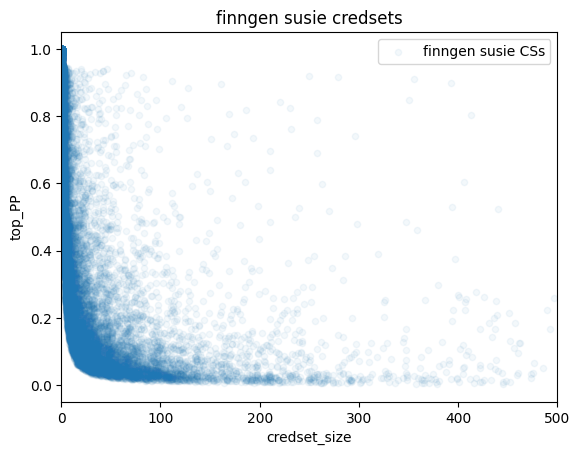

In [5]:
# study_index='gs://genetics_etl_python_playground/releases/24.03/study_index'
# Study Index. It has different files for different datasource (FinnGen, GWASCat, eQTLcat).
# Credible_set. Please use Daniels’ notebook as a reference. For each subfolder:

finngen_index_path=f"{release_path}/{release_ver}/study_index/finngen"
# finngen susie:
finngen_susie_path=f"{release_path}/{release_ver}/credible_set/finngen_susie"

finngen_susie=session.spark.read.parquet(finngen_susie_path, recursiveFileLookup=True)

# FinnGen:
finngen_index=session.spark.read.parquet(finngen_index_path, recursiveFileLookup=True)
# Number of CSs, studies.
sample_size_quartiles = finngen_index.stat.approxQuantile("nSamples", [0.25, 0.5, 0.75], 0.01)
# Number of unique studyids with at leas one CS.
# Number of CSs with at leas one SNP with PIP>0.9
# The descriptive summary of 99% CS size and histogram/density plot

credset_size_quartiles = finngen_susie.select("studyId", "region", "credibleSetIndex", "locus.posteriorProbability").withColumn("credset_size", f.size(f.col("posteriorProbability"))).stat.approxQuantile("credset_size", [0.25, 0.5, 0.75], 0.01)

finngen_susie.select("studyId", "region", "credibleSetIndex", "locus.posteriorProbability").withColumn("top_PP", f.col("posteriorProbability").getItem(0)).withColumn("credset_size", f.size(f.col("posteriorProbability"))).toPandas().plot.scatter(x="credset_size", y="top_PP", xlim=[0, 500], alpha=0.05, label="finngen susie CSs", title="finngen susie credsets")

finngen_susie_fm=finngen_susie.select("studyId", "studyLocusId", "locus.posteriorProbability").withColumn("top_PP", f.col("posteriorProbability").getItem(0)).withColumn("credset_size", f.size(f.col("posteriorProbability")))
# The histogram/density plot for total sample size
#finngen_index.select(f.col("nSamples")).toPandas().plot.hist(bins=10, alpha=0.5, label="FinnGen sample size", title="FinnGen sample sizes")

Number of unique finngen pics CSs:  19967  in  1342  studies.


Number of finngen_pics CS with top SNP PP > 0.9:  7239
Summary of finngen_pics sample sizes: L.quart:  316100.0 Median:  392089.0 U.quart:  409683.0
Summary of finngen_pics credset sizes: Mean:  36.04337156307908 L.quart:  1.0 Median:  7.0 U.quart:  30.0


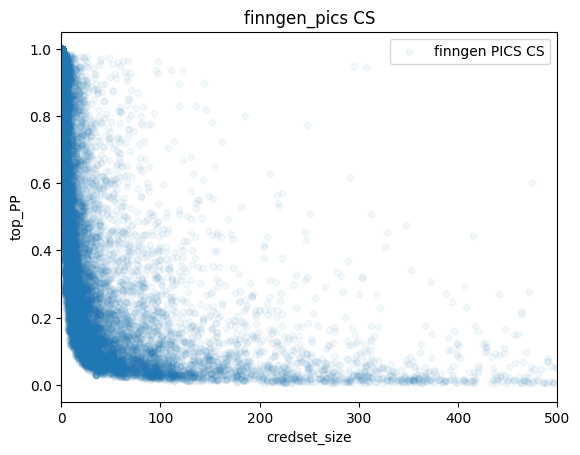

In [6]:

# finngen (PICs):
finngen_index_path=f"{release_path}/{release_ver}/study_index/finngen"
finngen_index=session.spark.read.parquet(finngen_index_path, recursiveFileLookup=True)
finngen_pics_path=f"{release_path}/{release_ver}/credible_set/finngen_pics"
# Number of CSs.
finngen_pics=session.spark.read.parquet(finngen_pics_path, recursiveFileLookup=True)
#gwascat_sumstats.printSchema()
# keep only credible sets snps

finngen_pics_fm=finngen_pics.select("studyId", "studyLocusId", "locus.posteriorProbability").withColumn("top_PP", f.col("posteriorProbability").getItem(0)).withColumn("credset_size", f.size(f.col("posteriorProbability")))
finngen_pics_fm.select("credset_size", "top_PP").toPandas().plot.scatter(x="credset_size", y="top_PP", alpha=0.05, xlim=[0, 500], label="finngen PICS CS", title="finngen_pics CS")
sample_size_quartiles = finngen_index.stat.approxQuantile("nSamples", [0.25, 0.5, 0.75], 0.01)

sample_size_quartiles = finngen_pics_fm.stat.approxQuantile("credset_size", [0.25, 0.5, 0.75], 0.01)

There are  9966  common loci between finngen susie and finngen pics


correlation coef:  0.6244595901320829


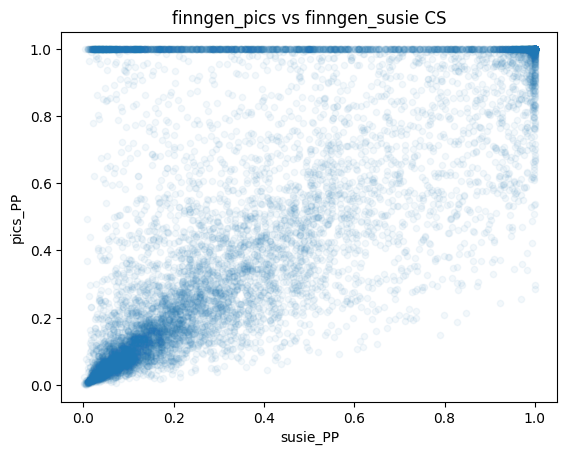

In [8]:
finngen_matching=finngen_pics_fm.withColumnRenamed("top_PP", "pics_PP").join(finngen_susie_fm.withColumnRenamed("top_PP", "susie_PP"), on=["studyId", "studyLocusId"], how="inner")
finngen_matching.select("pics_PP", "susie_PP").toPandas().plot.scatter(x="susie_PP", y="pics_PP", alpha=0.05, title="finngen_pics vs finngen_susie CS")

In [9]:
eqtl_index_path=f"{release_path}/{release_ver}/study_index/eqtl_catalogue"
# eQTLcat:
# Number of studies
eqtl_index=session.spark.read.parquet(eqtl_index_path, recursiveFileLookup=True)
# Number of tissues, list of tissues
#eqtl_index.select(f.col("biosampleFromSourceId")).distinct().show(truncate=False)

# Credible_set. Please use Daniels’ notebook as a reference. For each subfolder:
# eqtl catalog susie:
eqtlcat_susie_path=f"{release_path}/{release_ver}/credible_set/eqtl_catalogue_susie"
# Number of CSs.
eqtlcat_susie=session.spark.read.parquet(eqtlcat_susie_path, recursiveFileLookup=True)


# Number of CSs, studies.
sample_size_quartiles = eqtl_index.stat.approxQuantile("nSamples", [0.25, 0.5, 0.75], 0.01)
# Number of unique studyids with at leas one CS.
# Number of CSs with at leas one SNP with PIP>0.9
# The descriptive summary of 99% CS size and histogram/density plot

credset_size_quartiles = eqtlcat_susie.select("studyId", "region", "credibleSetIndex", "locus.posteriorProbability").withColumn("credset_size", f.size(f.col("posteriorProbability"))).stat.approxQuantile("credset_size", [0.25, 0.5, 0.75], 0.01)

# Out of mem error:
#eqtlcat_susie.select("studyId", "region", "credibleSetIndex", "locus.posteriorProbability").withColumn("top_PP", f.col("posteriorProbability").getItem(0)).withColumn("credset_size", f.size(f.col("posteriorProbability"))).toPandas().plot.scatter(x="credset_size", y="top_PP", xlim=[0, 500], alpha=0.05, label="finngen susie CSs", title="finngen susie credsets")


Number of unique eQTLcat studies:  1801315


Number of unqiue eQTLcat tissues:  76


Ingested  2055350  Credible sets from 1801315 eQTL catalog studies


Summary of eQTL catalog sample sizes: Mean:  336.1455965527037 L.quart:  190.0 Median:  322.0 U.quart:  483.0


Number of eQTL catalog studies with at least one CS:  1801315


Number of CS with top SNP PP > 0.9:  386227


Summary of eQTL credible set sizes: L.quart:  3.0 Median:  10.0 U.quart:  27.0


Number of unique gwascat studies:  79858
Number of unique SUMSTATS gwascat studies:  18435


Number of unique gwas catalog sumstats CSs:  247782  in  9679  studies.
Summary of SUMSTATS gwas sample sizes: L.quart:  88329.0 Median:  357580.0 U.quart:  445573.0


Number of SUMSTATS CS with top SNP PP > 0.9:  77721


Summary of SUMSTATS gwascat pics credset sizes: Mean:  39.7659733230078 L.quart:  1.0 Median:  8.0 U.quart:  35.0


Number of unique gwas catalog curated CSs:  531198  in  35662  studies.


Number of CURATED CS with top SNP PP > 0.9:  92000
Summary of CURATED gwas sample sizes: L.quart:  687.0 Median:  4960.0 U.quart:  21282.0


Summary of CURATED gwascat pics credset sizes: Mean:  35.42119007174911 L.quart:  1.0 Median:  8.0 U.quart:  34.0


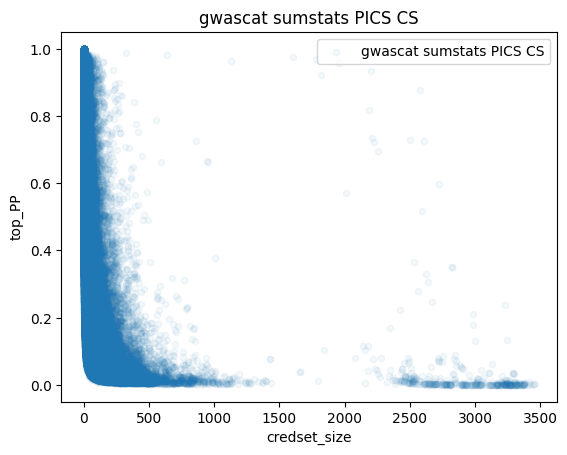

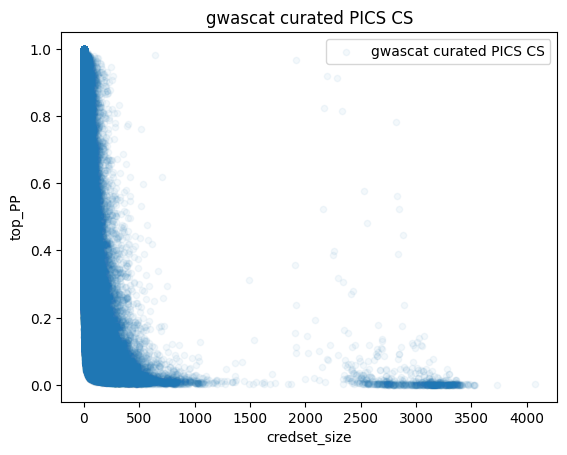

In [10]:
gwascat_path=f"{release_path}/{release_ver}/study_index/gwas_catalog"
# Gwas Catalog:
gwascat_index=session.spark.read.parquet(gwascat_path, recursiveFileLookup=True)
# Number of GWAS curated studies
# Number of studies with full GWAS sumstats
#gwascat_index
# The histogram/density plot for total sample size separately for curated studies and full GWAS
#gwascat_index.filter(f.col("hasSumstats") == True).select(f.col("nSamples")).toPandas().plot.hist(bins=25, alpha=0.5, label="Sumstats GWAScat sample size", title="Sumstats GWAScat sample size")
#gwascat_index.filter(f.col("hasSumstats") == False).select(f.col("nSamples")).toPandas().plot.hist(bins=25, alpha=0.5, label="Sumstats GWAScat sample size", title="Curated GWAScat sample size")

# Credible_set. Please use Daniels’ notebook as a reference. For each subfolder:
# gwas catalog sumstats (PICs):
gwascat_sumstats_path=f"{release_path}/{release_ver}/credible_set/gwas_catalog_PICSed_summary_statistics"
# Number of CSs.
gwascat_sumstats=session.spark.read.parquet(gwascat_sumstats_path, recursiveFileLookup=True)



sample_size_quartiles = gwascat_index.join(gwascat_sumstats, how="inner", on="studyId").stat.approxQuantile("nSamples", [0.25, 0.5, 0.75], 0.01)


gwascat_sumstats_fm=gwascat_sumstats.select("studyId", "studyLocusId", "locus.posteriorProbability").withColumn("top_PP", f.col("posteriorProbability").getItem(0)).withColumn("credset_size", f.size(f.col("posteriorProbability")))
gwascat_sumstats_fm.select("credset_size", "top_PP").toPandas().plot.scatter(x="credset_size", y="top_PP", alpha=0.05, label="gwascat sumstats PICS CS", title="gwascat sumstats PICS CS")

sample_size_quartiles = gwascat_sumstats_fm.stat.approxQuantile("credset_size", [0.25, 0.5, 0.75], 0.01)


# gwas catalog curated (PICs):
gwascat_curated_path=f"{release_path}/{release_ver}/credible_set/gwas_catalog_PICSed_curated_associations"
# Number of CSs.
gwascat_curated=session.spark.read.parquet(gwascat_curated_path, recursiveFileLookup=True)
#gwascat_sumstats.printSchema()
# keep only credible sets snps

gwascat_curated_fm=gwascat_curated.select("studyId", "studyLocusId", "locus.posteriorProbability").withColumn("top_PP", f.col("posteriorProbability").getItem(0)).withColumn("credset_size", f.size(f.col("posteriorProbability")))
gwascat_curated_fm.select("credset_size", "top_PP").toPandas().plot.scatter(x="credset_size", y="top_PP", alpha=0.05, label="gwascat curated PICS CS", title="gwascat curated PICS CS")
sample_size_quartiles = gwascat_index.join(gwascat_sumstats, how="anti", on="studyId").stat.approxQuantile("nSamples", [0.25, 0.5, 0.75], 0.01)

sample_size_quartiles = gwascat_curated_fm.stat.approxQuantile("credset_size", [0.25, 0.5, 0.75], 0.01)

##### 6. Analyze colocalization data:
   - Count the total number of colocalizations and the number with clpp > 0.8.
   - Calculate the average number of overlaps per credible set.

In [18]:
coloc_path=f"{release_path}/{release_ver}/colocalisation"
coloc=session.spark.read.parquet(coloc_path, recursiveFileLookup=True)

Avg_overlaps=coloc.groupBy("leftStudyLocusId").count().agg(f.avg("count")).collect()[0][0]



Number of colocalisations:  46733065  , of which,  4031821  > 0.8 clpp ( 8.6 %)


Average number of overlaps per CS:  90.79159130338489


##### 7. Analyze locus-to-gene (L2G) predictions:
   - Histogram of l2g score distribution.
   - Number of CS with at least one gene with L2G>=0.5
   - Number of CS with more than one gene with L2G>=0.5

A total of  10561869 l2g predictions were computed.


There are 8591772  UNIQUE locus to gene predictions for 607372  unique studyloci


Where  357875  studyloci contains at least one gene with score > 0.5


Of these,  122485  studyloci contains more than one gene with score > 0.5


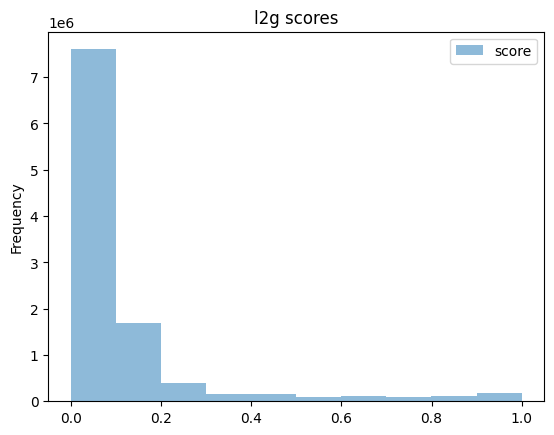

In [12]:
l2g_path=f"{release_path}/{release_ver}/locus_to_gene_predictions"
l2g=session.spark.read.parquet(l2g_path, recursiveFileLookup=True)
l2g.select("score").toPandas().plot.hist(bins=10, alpha=0.5, title="l2g scores")

# There are duplicated l2g predictions studyLocusId with finngen pics and susie

There are definitely duplicated studylocusIDs in the l2g predictions, and still around 20% of studylocus contains more than 1 gene with score>0.5. It is not possible to separate out these predictions based on whether they came from pics or susie,  as the l2g outputs only contains the studylocusID (duplicated between pics and susie). 

If 20% is too high then it implies finngen pics and susie l2g are pointing (confidently) at different genes for the same studylocus.


##### 7. Analyze locus-to-gene (L2G) predictions:
   - Consider only the top gene assignments from l2g:

<Axes: title={'center': 'l2g scores (top gene assignment)'}, ylabel='Frequency'>

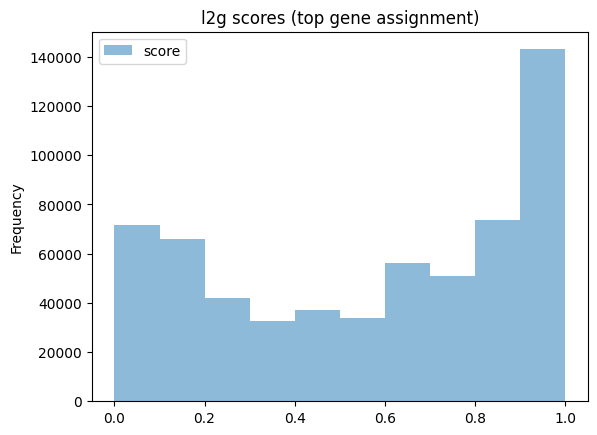

In [13]:
from pyspark.sql import Window

window = Window.partitionBy(l2g["studyLocusId"]).orderBy(l2g["score"].desc())
l2g = l2g.withColumn("rn", f.row_number().over(window))
l2g_max_scores = l2g.filter(l2g["rn"] == 1).drop("rn")
l2g_max_scores.select("score").toPandas().plot.hist(bins=10, alpha=0.5, title="l2g scores (top gene assignment)")

##### 7. Analyze locus-to-gene (L2G) predictions:
   - Consider only the top gene assignments from l2g:
   - How does this look when separated by datasource?

Summary of finngen PICS l2g scores: mean: 0.5615633023783144 L.quart:  0.2371208220720291 Median:  0.6145811676979065 U.quart:  0.8626531362533569


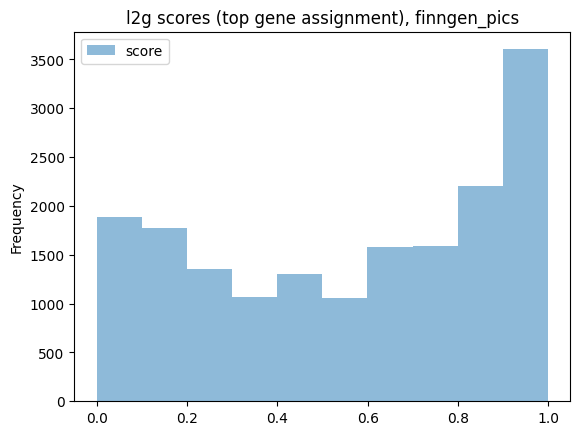

In [14]:
l2g_finngen_pics=l2g_max_scores.join(finngen_pics.select("studyLocusId", "studyId"), on="studyLocusId", how="inner")
l2g_finngen_pics.select("score").toPandas().plot.hist(bins=10, alpha=0.5, title="l2g scores (top gene assignment), finngen_pics")

sample_size_quartiles = l2g_finngen_pics.stat.approxQuantile("score", [0.25, 0.5, 0.75], 0.01)

Summary of l2g_finngen_susie: mean: 0.5593829938336615 L.quart:  0.2241434007883072 Median:  0.6244931817054749 U.quart:  0.8736903071403503


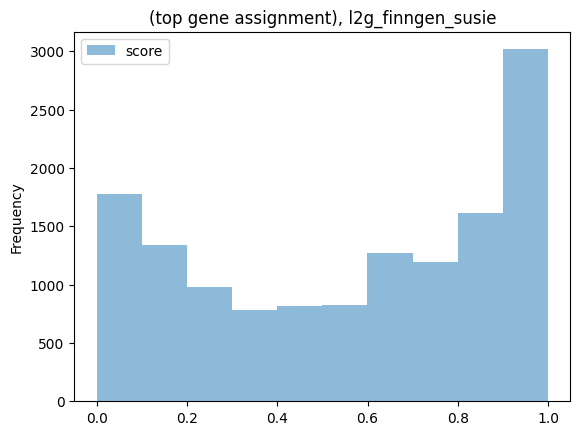

In [15]:
l2g_finngen_susie=l2g_max_scores.join(finngen_susie.select("studyLocusId", "studyId"), on="studyLocusId", how="inner")
l2g_finngen_susie.select("score").toPandas().plot.hist(bins=10, alpha=0.5, title="(top gene assignment), l2g_finngen_susie")

sample_size_quartiles = l2g_finngen_susie.stat.approxQuantile("score", [0.25, 0.5, 0.75], 0.01)

Summary of l2g_gwas_curated PICS l2g scores: mean: 0.5761322645683256 L.quart:  0.22704362869262695 Median:  0.653652012348175 U.quart:  0.8937538862228394


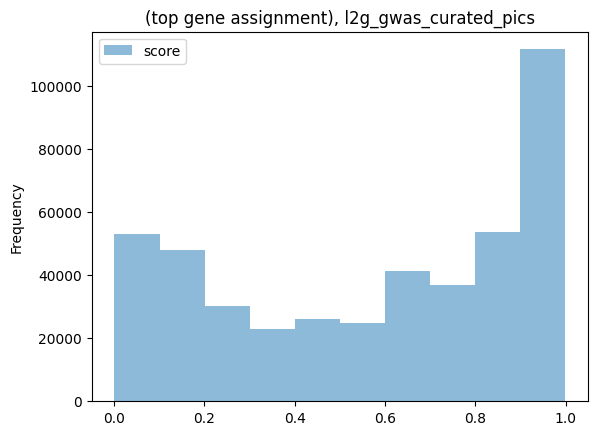

In [16]:
l2g_gwas_curated=l2g_max_scores.join(gwascat_curated.select("studyLocusId", "studyId"), on="studyLocusId", how="inner")
l2g_gwas_curated.select("score").toPandas().plot.hist(bins=10, alpha=0.5, title="(top gene assignment), l2g_gwas_curated_pics")

sample_size_quartiles = l2g_gwas_curated.stat.approxQuantile("score", [0.25, 0.5, 0.75], 0.01)

Summary of l2g_gwas_sumstats PICS l2g scores: mean: 0.5751686123272477 L.quart:  0.23706066608428955 Median:  0.647024929523468 U.quart:  0.8808161020278931


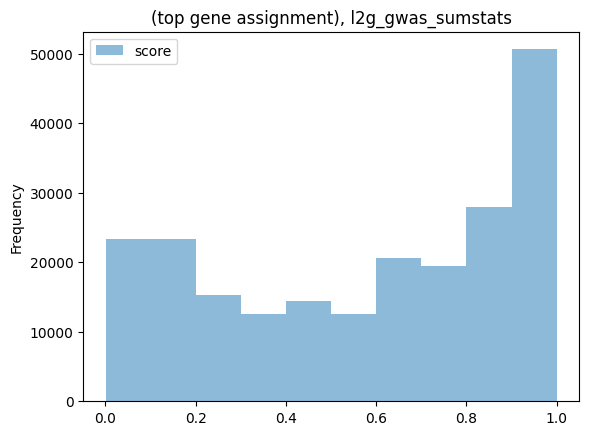

In [17]:
l2g_gwas_sumstats=l2g_max_scores.join(gwascat_sumstats.select("studyLocusId", "studyId"), on="studyLocusId", how="inner")
l2g_gwas_sumstats.select("score").toPandas().plot.hist(bins=10, alpha=0.5, title="(top gene assignment), l2g_gwas_sumstats")

sample_size_quartiles = l2g_gwas_sumstats.stat.approxQuantile("score", [0.25, 0.5, 0.75], 0.01)